# Report: Has twitter become more toxic?
*Žan Stanonik, Damla Cinel, Lorenz Mangold*   
-> TODO spell check the whole thing

In the light of the recent events at the beginning of the seminar Computational Social Science, our team decided to take a look into how the take over of Twitter by Elon Musk impacted the platform (acquisition happened on 27.10.2022).   
We specifically focused on toxicity, since it was most discussed in the media and a lot of people hinted at increase in racism, bullying and other forms of toxicity.

## 1. Theory and data selection
We couldn't just download all the Tweets from a given point in time to the given date, due to the limitations of the Twitter API and the lack of compute and storage resources on our side.    

Keeping these limitations in mind, we decided to only look at certain "subsets" of Twitter data, which we approximated with hashtags/keywords. We collected only the Tweets that fulfilled the following criteria:
1. They contained the following hashtags/keywords: 
  * trump
  * musk 
  * fitness
  * netflix
  * vegan
  * vegeterian
  * uno
2. They were in English
3. They weren't retweets
4. They didn't have links
5. They weren't replies 
6. They weren't quoting other tweets   
   
With these limitations we wanted to removed tweets that we couldn't process properly, tweets that were posted by bots, tweets out of context, and scammer tweets with links to other webpages. Our hope was that with these limitation we would only gather tweets where people truly voice there opinions and we could gather all of them.

We only looked at the time period from 01/06/2022 to 03/01/2023 which resulted in 216 days of data collection, so that we could really gather all the tweets on this data subset since we were limited with the Twitter Academic API (and its 10 million tweets).



## 2. Data gathering 
Working on the limitations and specifics we set in the previous chapter we researched how we can actually gather the Tweets that we are interested in. We tested out various libraries such as [Tweepy](https://www.tweepy.org/), but we found out it was too limiting for us. Hence we decided to design our own function for retriving the tweets, and it resulted in the following main function:

In [ ]:
from src.twitter_download_functions import download_tweets

search_query = "( vegan OR #vegan ) lang:en -is:retweet -is:quote -has:links -is:reply"
download_tweets(search_query=search_query, 
                tweets_per_day=18000, 
                start_time="01/06/2022 00:00", 
                end_time="03/01/2023 00:00")

With this kind of set up we specified the query that should be passed to the Twitter Academic in the function parameter `search_query`, while the other parameters were processed on our side locally and added additional information to the query.   

The information they added was mainly the time from which the tweets should be gathered, since our method split the day into `tweets_per_day` // 500 intervals, because the current API documentation said that it is unable to provide more than 500 tweets per request. In this case the day would be split into 36 equal time intervals.
   
Another limitation of the Twitter API is also that no more than 300 request can be sent in a 15 minute interval so the data gathering took a few days for all the tweets to be collected. Our final dataset was then comprised of 7 data files with a combined size of 1.14GB and contained ~5.5 million tweets.


Above you can see that amount of tweets collected for each hashtag.

## 3. Text preprocessing 

Now we had all the data that we needed, and we first feed it directly to the Detoxify model, but we realized this was bad practice and decided to preprocess text of each tweet to make the predictions more robust and to discard any weird symbols in the text. 
   
The text was preprocessed in the following order of steps:  
1. First we replaced all the weird symbols with non standard charaters such as emojis, non-english letters etc. with the help of regex.
2. Then we removed multiple spaces and new lines in strings to have continuous sentences.
3. We gave each tweet to the spacy 'en_core_web_sm' model which lemmatized the words into their base forms.  

All of the steps mentioned were packaged in a function used below:

In [ ]:
import spacy, re
from src.text_preparation import optimized_prepare_text_for_tweet_file

test_reg = re.compile("["
                      u"\U0001F600-\U0001F64F" 
                      u"\u3030"
                      "]+", re.UNICODE)
optimized_prepare_text_for_tweet_file(replace_symbols_regex=test_reg, 
                                      input_file="vegetarian_hashtag_6_1_2023.csv", 
                                      output_file_name="test_vegetarian_hashtag_6_1_2023.csv", 
                                      nlp_model=spacy.load('en_core_web_sm'))

We executed the following function on all the tweets that we gathered and saved the preprocessed text as an additional column in the csv files which resulted in data increasing to 1.9GB.

## 4. Toxicity metric generation

### 4.1 Perspective API
Intially our goal was to use the [Perspective API](https://perspectiveapi.com/) offered by Google to acquire the toxicity metrics from the tweets we gathered. It turned out that the API is pretty limited in the amount of request per second you can request from it, and even though we received an increase of request per second, we calculated that we would need at least 8 days to get the metrics for all 5.5 million tweets. Therefore we abandoned this approach due to time limitations, and additional work that would be needed to make it possible to send more request per second to the API.

-> TODO Lorenz add something if you think it is needed


### 4.2 Detoxify library
When we abandoned the initial apprach with the Perspective API we began searching for alternatives and we found the [Detoxify python library](https://pypi.org/project/detoxify/) which seemed straight forward to use, and was built on top of models who won multiple Kaggle competitions.

We then designed a function which used the bert base uncased model provided by the library to predict the toxicity metric. When feeding the tweets to the model we made sure to split each tweet into sentences and aquire each sentence toxicity separately, and averaged the toxicity over all the sentences for each tweet to make the predictions more robust.

Due to the large amount of data we were working with we added intermidiate saving of the tweets and the metrics during the execution to reduce the memory load, and we also loaded the model to the GPU with the help of CUDA which speed up the execution by a factor of 5x. An example of the developed function can be seen below:

In [ ]:
from detoxify import Detoxify
from src.toxicity_metric_generation_functions import upgraded_generate_toxicity_for_tweet_file

upgraded_generate_toxicity_for_tweet_file(model=Detoxify("original", device="cuda"), 
                                          input_file="vegetarian_hashtag_6_1_2023_lemmatized.csv", 
                                          output_file="vegetarian_hashtag_6_1_2023_lemm_test.csv")

This was ran for all the tweets in our data set, one time for the raw texts and one time for the preprocessed lemmatized text. We did this to compare the results and to see what kind of effect did the preprocessing of text had on the general change in toxicity metrics. 
With the added metrics we were now up to 2.59GB of data for both texts.

The toxicity metrics we generated were the following:
- toxicity
- severe toxicity
- obscene 
- threat
- insult 
- identity attack


## 5. Analysis 

### 5.1 Positive/negative word count
We started out with taking a look at positive and negative word counts, which were simpler to analyse and we could more easily interpret the results. Datasets of positive and negative words were collected and stored in `data/words_datasets`, then we just counted the number of words of each time and plotted the results.

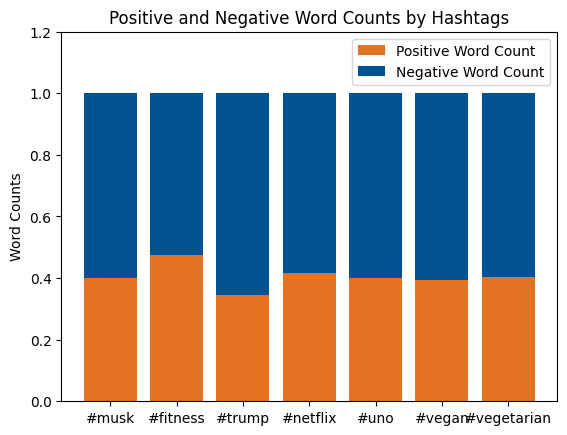

From the results it could be seen that fitness had the most positive words, which is likely due to the support in the community and people encouraging each other. While the tweets with the most negative data were the tweets related to Trump, which is also to be expected since Trump is a controversial figure and offended multiple groups of people during his political career.

### 5.2 Overall and single hashtag/keyword toxicity change through time 
After this we began to look at the toxicity metrics we generated, and tried to find an overall trend change in toxicity metrics. First we visualized the average daily toxicity metrics for all the tweets collected and searched for any change after `27.10.2022`, which was the date that Musk took over Twitter. 


From the chart above it seemed that the toxicity metrics stayed almost the same during the whole time period, we therefore decide to compute relative change in the metrics of the post-take over tweets compared to the pre-take over ones.


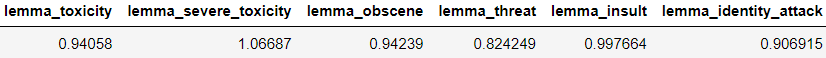   

Change between the metrics with this implied that 5 out 6 toxicity metrics actually decreased when looking at all the tweets collected. While the only metrics that increased was `severe toxicity` by 6.7%. It worth noting here that had an imbalanced data set with almost two times as many tweets collected pre-take over as post-take, which could be the reason for some of the change in data and the post-take over data set also had corresponding larger standard deviations in metrics because of this.

We then decided to look at keywords/hashtags in isolation and especially focused on the musk one. It turned out that there we actually saw spikes in toxicity, that matched important events during the take over. On the charts above we can see three most prominent examples of this, the first one on the **27.10.2022** when the take over happened, **4.11.2022** when he fired half of the employees, and on the **16.12.2022** when he banned a journalist reporting his realtime location.




In this case we see that the spikes in toxicity match up, since they were mostly aimed at Elon Musk and his actions. The timeline of the events about the Twitter take over can be checked [here](https://www.searchenginejournal.com/elon-musks-twitter-takeover-a-timeline-of-events/470927/#close).

*In the poster we wrongly labeled two events, so refer to this report as the accurate chart.*

### 5.3 Most toxic tweets 
To see if the toxicity metrics make any sense, we looked at the tweets classified as most toxic to see if they are actually toxic according to our own interpretation.
   
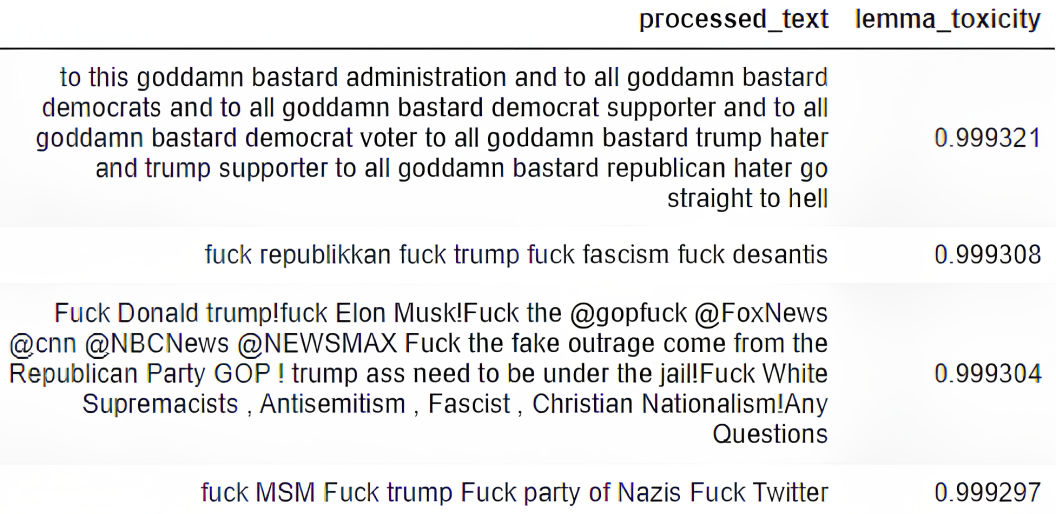


After looking at tweets ranked as the most toxic on other metrics not you toxicity, we concluded that the model performs well.

### 5.4 Change of toxicity metrics after take over

Lastly we looked at the change of each metric depending on the hashtag. Below we can see the change in the toxicity metric for each hashtag, we can see that most of the hashtags/keywords experienced a decrease in toxicity, except for Musk which increased by over 30%. We also see that Netflix experienced a severe drop in it, but that can be attributed to more controversial movies/series being release during the pre-take over period.



On the following chart we focus on the identity attack metric, and we see that again tweets related to Musk experienced a severe increase, Trump also experienced an increase which could be the result of Musk unbanning his Twitter account. We didn't manage to find any meaningful reasoning about the changes of other hashtags. 



### 5.5 Preprocessed and raw text toxicity comparison

Since we spent a lot of computation resources and time for text lemmatization, we wanted to know if has any additional benefit in terms of robustnes of predictions. From the comparison analysis that we performed between raw and processed text, we found that the standard deviation of toxicity metrics reduced for most of the metrics, but not for a large margin (~0.5 to ~5.5%). While for the threat metric the lemmatization actually increased the standard deviation by 22%.



Toxicity results for the mean toxicity metrics also varied a lot with two of the metrics experiencing small increases, three experiencing decreases, and with threat again experiencing the biggest change of 50% more average toxicity.    
   
These results should be explored further to determine if the extra computation is worth the resources spent, but for now it seems that the Detoxify model can deal with raw text while still providing good results. So it might be worth abandoning the text preprocessing step if time is of the essence, and we wouldn't have enough compute resources.

## 6. Conclusions

To sum it up, we could not find convincing evidence, that Twitter has become more Toxic in general since the takeover, but we found the following:
- Tweets talking about Elon Musk are **significantly more toxic**, which we proved with a t-test
- A lot of tweets achieved a **high level of toxicity**, yet the users were **still able to post them**
- Through word analysis we found out, that **Trump related tweets had the most negative words** 
- We included only original tweets, since the amount of spam-tweets was too high
- The tweets **not related** to Elon Musk experienced a **small decrease in toxicity** post-takeover

## 7. Future work
If we decide to take this project forward, or anyone wishes to carry it on we would improve on the following:
1. **Gather more data**. At first we were limited by the Twitter API and us not having proper methods to retrieve the data, but with the software we developed this is now possible and we could collect at ~30 million Tweets with relative ease. This means including even more hashtags/keyswords to get a even broader outlook on the whole Twitter landscape.

2. **Expand data collection time intervals**. The data we gathered now was collected as already mentioned from 01/06/2022 to 03/01/2023. To have an complete look at the take over, the data collection start date should be March 25, 2022 (or even earlier), when Musk first began critizing Twitter about their free speech policy. While the end date should be far enough in the future to observe the effects that began to show later, after the users were already engaged in the new system, as the time of writting this we could get the data at least until March 3, 2023. With this we would already almost double the amount of post-take over days (and with this the amount of available tweets).

3. **Perpective API parallel approach (or in general multiple model approach)**. Evaluate all the gathered data also on the Perspective API, for which we ran out of time to do, and only compared data subsets. With this we would ensure that the models used for predicting toxicity have consensus among them, and with this we would elimate bias that might be present inside a single model.

4. Of course a bunch of other improvements could be made from optimizing code execution times, adding test, creating a dashboard for interactive real-time analysis of Tweets. But these approaches will be explored at a later date.